# TODO

* Run mouse max-d analysis for the mouse data without changes-of-mind
* Run RT analysis for mouse data
* Run max-d and RT analyses for cleaned walking data
* Run frequentist regressions

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Lambda$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 
* Check sensitivity of max-d/RT to $\Lambda$ separately for high and low discounters. Most participants are high discounters, and for them almost all decisions are equally easy, so max-d wouldn't depend on $\Lambda$. However, for someone with a more balanced distribution of SS/LL choices, we would expect this effect.

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.

In [2]:
get_processed_data <- function(){
    filename <- "C:/Users/Arkady/Google Drive/data/beyond_the_reach/choices_processed.txt"
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])
    data[, 'choice'] <- factor(data[, 'choice'])
    
    return(data)
}

In [3]:
data <- get_processed_data()

In [4]:
nrow(data)/94

[1] 60

In [5]:
data <- get_processed_data()
mouse_data <- data[data$task=='mouse',]
# discarding missing values
mouse_data <- mouse_data[complete.cases(mouse_data[ , 'max_d']),]

walking_data <- data[data$task=='walking',]
walking_data <- walking_data[complete.cases(walking_data[ , 'max_d']),]

In [6]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter))
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior)
    }
    return(model)
}

run_analysis <- function(var, data, rscale){
    " This function runs our analysis for a particular dataset (fake or real) and given DV (var).
    The rscale parameter defines the scale of prior distribution on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, var])/sd(data[, 'Lambda'])), class = "b"))

    formulas <- list(f_inter = as.formula(paste(var, "~ (choice | subj_id) + Lambda:choice")),
                     f_choice = as.formula(paste(var, "~ (choice | subj_id)")),
                     f_null = as.formula(paste(var, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    return(bf_result)
}

# Mouse data: max-d

In [68]:
# rt_bf <- run_analysis('RT', data, 0.707)
max_d_bf <- run_analysis('max_d', mouse_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.116 seconds
1000 transitions using 10 leapfrog steps per transition would take 1160 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 38.482 seconds (Warm-up)
               26.359 seconds (Sampling)
               64.841 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0.015 seconds
1000 transitions using 10 leapfrog steps per transition would take 150 s

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.018 seconds
1000 transitions using 10 leapfrog steps per transition would take 180 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 26.29 seconds (Warm-up)
               19.917 seconds (Sampling)
               46.207 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 11.286 seconds (Warm-up)
               5.017 seconds (Sampling)
               16.303 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust

In [69]:
max_d_bf$bf

1.035192e+66,2.997306e+67,27.86666


In [10]:
spaghetti <- function(model, var, ylabel){
    plt_dat <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=800), plot=FALSE)
    plt_dat <- plt_dat$"Lambda:choice" + 
#         geom_point(aes_string(x="Lambda", y=var, shape='choice', colour='choice'), size = 3, alpha=0.6, data = data) +
        theme_pander(base_size = 14) +
        xlab(TeX('Advantage of LL option ($\\lambda$)')) +
        ylab(ylabel) +
        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)

    plot(plt_dat)
#     ggsave(sprintf('figures/spaghetti_%s.png', var), dpi=300) 
}

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


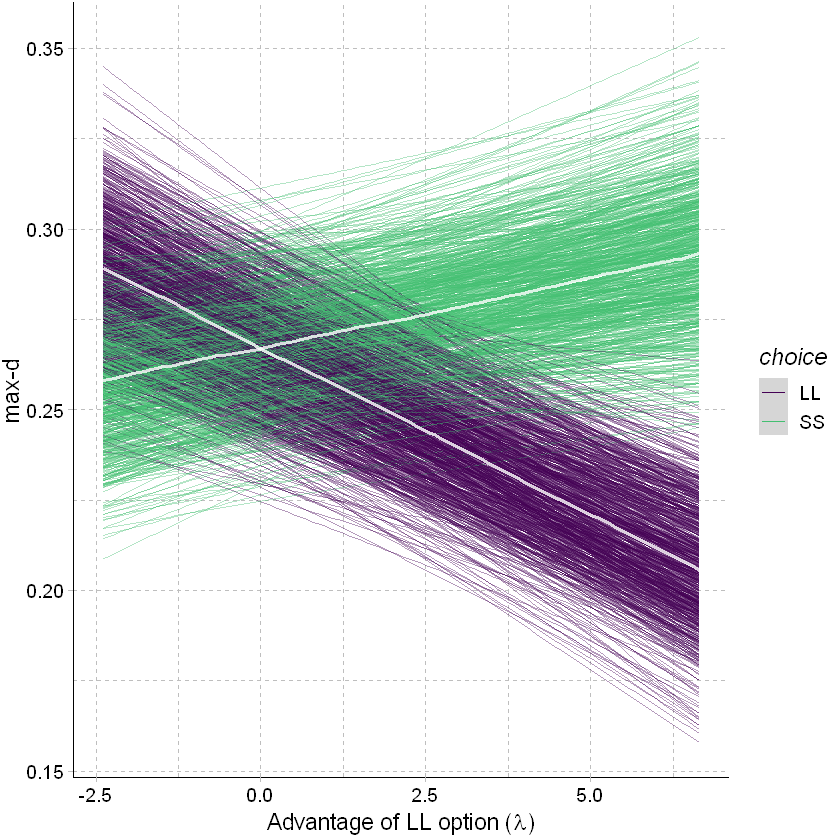

In [70]:
# spaghetti(rt_bf$models$m_inter, 'RT', 'RT')
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

In [71]:
m <- as.mcmc(max_d_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs.csv")

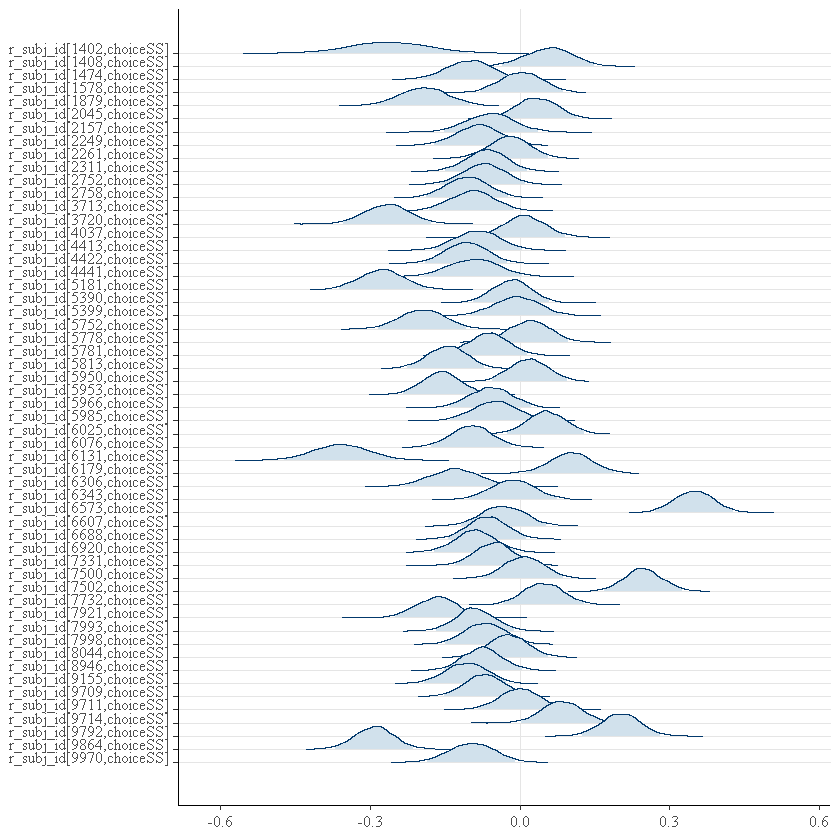

In [55]:
mcmc_areas_ridges(as.matrix(m), regex_pars = ",choice", prob=0.95) 

# Walking data 

In [7]:
max_d_bf <- run_analysis('max_d', walking_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 30.6 seconds (Warm-up)
               12.092 seconds (Sampling)
               42.692 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust 

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 17.346 seconds (Warm-up)
               8.722 seconds (Sampling)
               26.068 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
A

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 5.906 seconds (Warm-up)
               2.557 seconds (Sampling)
               8.463 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust y

In [8]:
#     bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
max_d_bf$bf

9.706297e+38,4.306915e+36,0.004555324


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


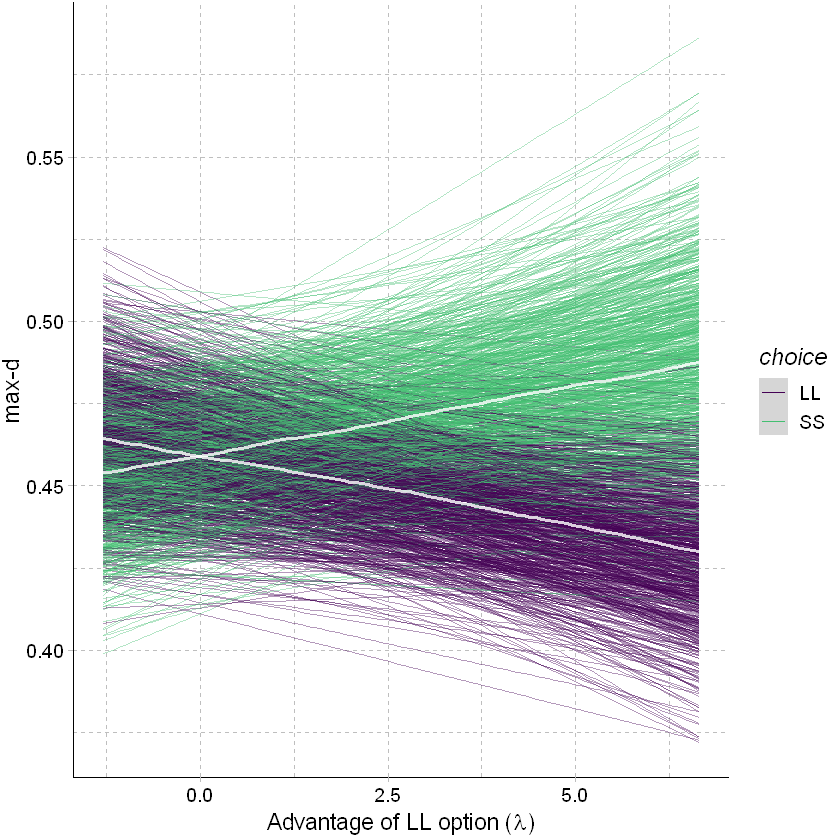

In [11]:
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

,lower,upper
b_Lambda:choiceLL,-0.011134816,0.002008149
b_Lambda:choiceSS,-0.002868307,0.011083805


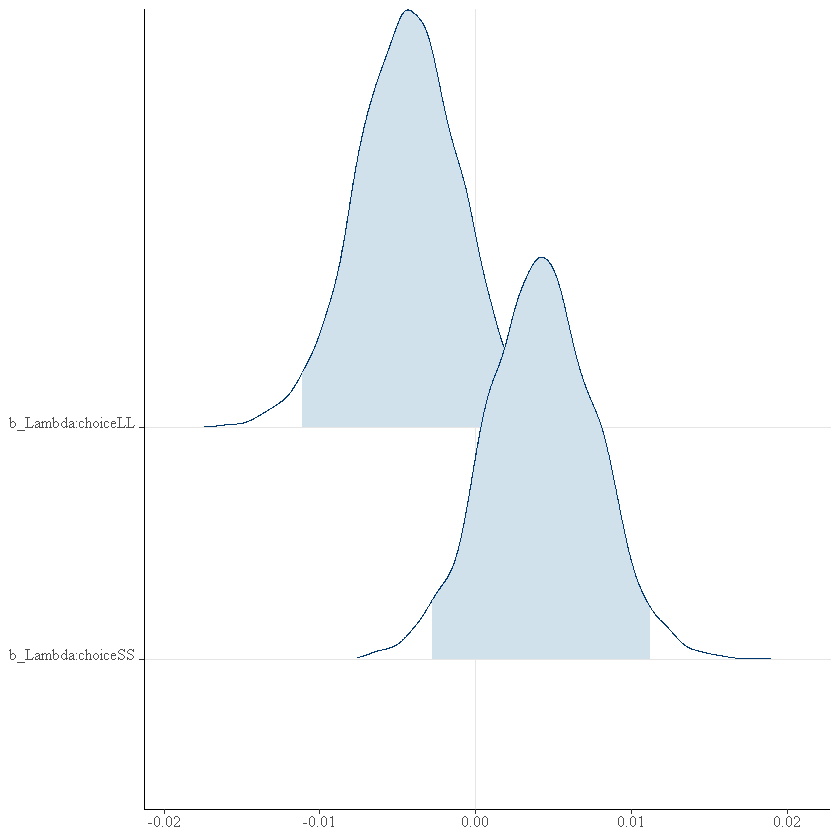

In [19]:
hpd_inter<-HPDinterval(as.mcmc(max_d_bf$models$m_inter, combine_chains = TRUE))

mcmc_areas_ridges(as.matrix(as.mcmc(max_d_bf$models$m_inter, combine_chains = TRUE)), regex_pars = "b_Lambda", prob=0.95)
hpd_inter[c('b_Lambda:choiceLL', 'b_Lambda:choiceSS'),]